In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
organizations_theworldbank_world_bank_intl_debt_path = kagglehub.dataset_download('organizations/theworldbank/world-bank-intl-debt')

print('Data source import complete.')


# Introduction



In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import os
print(os.listdir("../input/"))


[]


This is a big query dataset so we use the bq_helper library for query searching. If you are unfamiliar with bigquery, Here is very good [tutorial](https://medium.com/google-cloud/getting-started-with-google-cloud-a-codelab-for-geohackweek-2017-848c25ed72fd) on Medium. If you don't feel like reading it, In layman terms, you can just think bigquery as big SQL queries.

In [ ]:
import bq_helper
from bq_helper import BigQueryHelper
wbid = bq_helper.BigQueryHelper(active_project="bigquery-public-data",
                                   dataset_name="world_bank_intl_debt")

In [ ]:
bq_assistant = BigQueryHelper("bigquery-public-data", "world_bank_intl_debt")
bq_assistant.list_tables()

['country_series_definitions',
 'country_summary',
 'international_debt',
 'series_summary',
 'series_times']

In [ ]:
bq_assistant.head("international_debt", num_rows=5)

,country_name,country_code,indicator_name,indicator_code,value,year
0,Chad,TCD,GNI (current US$),NY.GNP.MKTP.CD,None,None
1,Chad,TCD,GNI (current US$),NY.GNP.MKTP.CD,None,None
2,Chad,TCD,GNI (current US$),NY.GNP.MKTP.CD,None,None
3,Chad,TCD,GNI (current US$),NY.GNP.MKTP.CD,None,None
4,Chad,TCD,GNI (current US$),NY.GNP.MKTP.CD,None,None


In [ ]:
# 1. Verify the number of unique economic indicators
query_indicators = """
SELECT COUNT(DISTINCT indicator_code) as unique_indicators
FROM `bigquery-public-data.world_bank_intl_debt.international_debt`
"""
indicators_result = wbid.query_to_pandas_safe(query_indicators)
print(f"\nNumber of unique economic indicators: {indicators_result['unique_indicators'][0]}")

query_countries = """
SELECT COUNT(DISTINCT country_code) as unique_countries
FROM `bigquery-public-data.world_bank_intl_debt.international_debt`
"""
countries_result = wbid.query_to_pandas_safe(query_countries)
print(f"Number of unique countries/regions: {countries_result['unique_countries'][0]}")

# # Optional: Explore indicator definitions (if a series table exists)
# query_series = """
# SELECT indicator_code, indicator_name
# FROM `bigquery-public-data.world_bank_intl_debt.series`
# LIMIT 5
# """
# series_result = wbid.query_to_pandas_safe(query_series)
# print("\nSample of economic indicators:")
# print(series_result)


Number of unique economic indicators: 497
Number of unique countries/regions: 135


countries that had the largest outstanding debt in 2016

In [ ]:
query1 = """
SELECT
  id.country_name,
  id.value AS debt --format in DataStudio
FROM (
  SELECT
    country_code,
    region
  FROM
    `bigquery-public-data.world_bank_intl_debt.country_summary`
  WHERE
    region != "" ) cs --aggregated countries do not have a region
INNER JOIN (
  SELECT
    country_code,
    country_name,
    value,
    year
  FROM
    `bigquery-public-data.world_bank_intl_debt.international_debt`
  WHERE
    indicator_code = "DT.DOD.PVLX.CD"
    AND year = 2016 ) id
ON
  cs.country_code = id.country_code
ORDER BY
  id.value DESC
;
        """
response1 = wbid.query_to_pandas_safe(query1)
response1.head(5)

,country_name,debt


# EDA

## Country series defination

In [ ]:
bq_assistant.head("country_series_definitions", num_rows=5)

,country_code,series_code,description
0,AFG,BX.KLT.DINV.CD.DT,Data on Foreign Direct Investment are based on...
1,AGO,BX.KLT.DINV.CD.DT,Data on Foreign Direct Investment are based on...
2,ALB,BX.KLT.DINV.CD.DT,Data on Foreign Direct Investment are based on...
3,ARG,BX.KLT.DINV.CD.DT,Data on Foreign Direct Investment are based on...
4,ARM,BX.KLT.DINV.CD.DT,Data on Foreign Direct Investment are based on...


In [ ]:
bq_assistant.table_schema('country_series_definitions')

[SchemaField('country_code', 'STRING', 'NULLABLE', None, ()),
 SchemaField('series_code', 'STRING', 'NULLABLE', None, ()),
 SchemaField('description', 'STRING', 'NULLABLE', None, ())]

**Let's check number of countries and series code in this table**

In [ ]:
# Number of countries
query2 = """
SELECT count(distinct country_code) from `bigquery-public-data.world_bank_intl_debt.country_series_definitions`
"""

# Number of series code
query3 = """
SELECT count(distinct series_code) from `bigquery-public-data.world_bank_intl_debt.country_series_definitions`
"""

# total rows in the table
query4 = """
SELECT count(country_code) from `bigquery-public-data.world_bank_intl_debt.country_series_definitions`
"""

In [ ]:
# Number of countries
response2 = wbid.query_to_pandas_safe(query2)
response3 = wbid.query_to_pandas_safe(query3)
response4 = wbid.query_to_pandas_safe(query4)
print('Total number of countries:', response2.at[0, 'f0_'])
print('Total number of series codes:', response3.at[0, 'f0_'])
print('Total number of rows:', response4.at[0, 'f0_'])

Total number of countries: 133
Total number of series codes: 6
Total number of rows: 263


In [ ]:
country_series_map_q = """
SELECT country_code, count(series_code) from `bigquery-public-data.world_bank_intl_debt.country_series_definitions` group by country_code
"""

In [ ]:
country_series_map = wbid.query_to_pandas_safe(country_series_map_q)
country_series_map.columns = ['country_code', 'total_series_per_country']

In [ ]:
country_series_map[country_series_map['total_series_per_country'] == country_series_map['total_series_per_country'].max()]

,country_code,total_series_per_country
51,IND,5


**India has taken highest types of debts. Pretty cool huh!**

1. Lets try this other way around

In [ ]:
series_country_map_q = """
SELECT series_code, count(country_code) from `bigquery-public-data.world_bank_intl_debt.country_series_definitions` group by series_code
"""

In [ ]:
series_country_map = wbid.query_to_pandas_safe(series_country_map_q)
series_country_map.columns = ['series_code', 'total_countries_per_series']

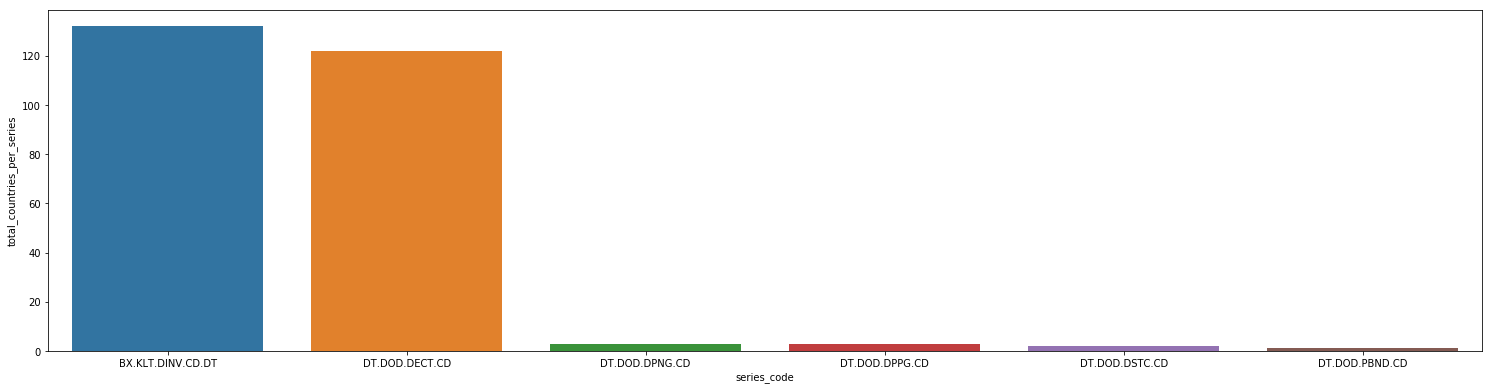

In [ ]:
a4_dims = (25.7, 6.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot('series_code', 'total_countries_per_series', data = series_country_map)
plt.show()

In [ ]:
query5 =  """
SELECT distinct(series_code), description from `bigquery-public-data.world_bank_intl_debt.country_series_definitions` where series_code = 'DT.DOD.DECT.CD'"""

In [ ]:
print('DT.DOD.DECT.CD is a ' + wbid.query_to_pandas_safe(query5).iloc[1,1])

DT.DOD.DECT.CD is a Long-term public and publicly guaranteed and long-term private nonguaranteed debt data for 2018 are based on reports provided by the country. Short-term debt data are not available.


In [ ]:
query6 =  """
SELECT distinct(series_code), description from `bigquery-public-data.world_bank_intl_debt.country_series_definitions` where series_code = 'BX.KLT.DINV.CD.DT'"""

In [ ]:
print('BX.KLT.DINV.CD.DT is ' + wbid.query_to_pandas_safe(query6).iloc[0,1])

BX.KLT.DINV.CD.DT is Data on Foreign Direct Investment are based on Balance of Payments reported by the International Monetary Fund. Unless otherwise specified in the specific years.


So we now understood coutry series mappping pretty well.

Moving further

## country_summary

In [ ]:
bq_assistant.head("country_summary", num_rows=5)

,country_code,short_name,table_name,long_name,two_alpha_code,currency_unit,special_notes,region,income_group,wb_2_code,national_accounts_base_year,national_accounts_reference_year,sna_price_valuation,lending_category,other_groups,system_of_national_accounts,alternative_conversion_factor,ppp_survey_year,balance_of_payments_manual_in_use,external_debt_reporting_status,system_of_trade,government_accounting_concept,imf_data_dissemination_standard,latest_population_census,latest_household_survey,source_of_most_recent_Income_and_expenditure_data,vital_registration_complete,latest_agricultural_census,latest_industrial_data,latest_trade_data,latest_water_withdrawal_data
0,EAP,East Asia & Pacific (excluding high income),East Asia & Pacific (excluding high income),East Asia & Pacific (excluding high income),4E,None,East Asia and Pacific regional aggregate (does...,None,None,4E,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,ECA,Europe & Central Asia (excluding high income),Europe & Central Asia (excluding high income),Europe & Central Asia (excluding high income),7E,None,Europe and Central Asia regional aggregate (do...,None,None,7E,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,IDX,IDA only,IDA only,IDA only,XI,None,IDA only group aggregate.,None,None,XI,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,LAC,Latin America & Caribbean (excluding high income),Latin America & Caribbean (excluding high income),Latin America & Caribbean (excluding high income),XJ,None,Latin America and Caribbean regional aggregate...,None,None,XJ,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,LDC,Least developed countries: UN classification,Least developed countries: UN classification,Least developed countries: UN classification,XL,None,Least developed countries (UN classification) ...,None,None,XL,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [ ]:
bq_assistant.table_schema('country_summary')

[SchemaField('country_code', 'STRING', 'NULLABLE', None, ()),
 SchemaField('short_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('table_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('long_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('two_alpha_code', 'STRING', 'NULLABLE', None, ()),
 SchemaField('currency_unit', 'STRING', 'NULLABLE', None, ()),
 SchemaField('special_notes', 'STRING', 'NULLABLE', None, ()),
 SchemaField('region', 'STRING', 'NULLABLE', None, ()),
 SchemaField('income_group', 'STRING', 'NULLABLE', None, ()),
 SchemaField('wb_2_code', 'STRING', 'NULLABLE', None, ()),
 SchemaField('national_accounts_base_year', 'STRING', 'NULLABLE', None, ()),
 SchemaField('national_accounts_reference_year', 'STRING', 'NULLABLE', None, ()),
 SchemaField('sna_price_valuation', 'STRING', 'NULLABLE', None, ()),
 SchemaField('lending_category', 'STRING', 'NULLABLE', None, ()),
 SchemaField('other_groups', 'STRING', 'NULLABLE', None, ()),
 SchemaField('system_of_national_acc

In [ ]:
response1 = wbid.query_to_pandas_safe("SELECT distinct(income_group) from `bigquery-public-data.world_bank_intl_debt.country_summary` ")
response1.head(10)

,income_group
0,None
1,Upper middle income
2,Lower middle income
3,Low income


In [ ]:
regions = wbid.query_to_pandas_safe("""SELECT * from `bigquery-public-data.world_bank_intl_debt.country_summary` where income_group = ''""")
regions.head()

,country_code,short_name,table_name,long_name,two_alpha_code,currency_unit,special_notes,region,income_group,wb_2_code,national_accounts_base_year,national_accounts_reference_year,sna_price_valuation,lending_category,other_groups,system_of_national_accounts,alternative_conversion_factor,ppp_survey_year,balance_of_payments_manual_in_use,external_debt_reporting_status,system_of_trade,government_accounting_concept,imf_data_dissemination_standard,latest_population_census,latest_household_survey,source_of_most_recent_Income_and_expenditure_data,vital_registration_complete,latest_agricultural_census,latest_industrial_data,latest_trade_data,latest_water_withdrawal_data


In [ ]:
response1 = wbid.query_to_pandas_safe("""SELECT short_name, income_group from `bigquery-public-data.world_bank_intl_debt.country_summary`""")
response1.head(5)

,short_name,income_group
0,East Asia & Pacific (excluding high income),None
1,Europe & Central Asia (excluding high income),None
2,IDA only,None
3,Latin America & Caribbean (excluding high income),None
4,Least developed countries: UN classification,None


** Let's checkout lending category attribute **

In [ ]:
response1 = wbid.query_to_pandas_safe("SELECT distinct(lending_category) from `bigquery-public-data.world_bank_intl_debt.country_summary` ")
response1

,lending_category
0,None
1,Blend
2,IBRD
3,IDA


In [ ]:
country_summary = wbid.query_to_pandas_safe("SELECT * from `bigquery-public-data.world_bank_intl_debt.country_summary` ")
country_summary.head()

,country_code,short_name,table_name,long_name,two_alpha_code,currency_unit,special_notes,region,income_group,wb_2_code,national_accounts_base_year,national_accounts_reference_year,sna_price_valuation,lending_category,other_groups,system_of_national_accounts,alternative_conversion_factor,ppp_survey_year,balance_of_payments_manual_in_use,external_debt_reporting_status,system_of_trade,government_accounting_concept,imf_data_dissemination_standard,latest_population_census,latest_household_survey,source_of_most_recent_Income_and_expenditure_data,vital_registration_complete,latest_agricultural_census,latest_industrial_data,latest_trade_data,latest_water_withdrawal_data
0,EAP,East Asia & Pacific (excluding high income),East Asia & Pacific (excluding high income),East Asia & Pacific (excluding high income),4E,None,East Asia and Pacific regional aggregate (does...,None,None,4E,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None
1,ECA,Europe & Central Asia (excluding high income),Europe & Central Asia (excluding high income),Europe & Central Asia (excluding high income),7E,None,Europe and Central Asia regional aggregate (do...,None,None,7E,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None
2,IDX,IDA only,IDA only,IDA only,XI,None,IDA only group aggregate.,None,None,XI,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None
3,LAC,Latin America & Caribbean (excluding high income),Latin America & Caribbean (excluding high income),Latin America & Caribbean (excluding high income),XJ,None,Latin America and Caribbean regional aggregate...,None,None,XJ,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None
4,LDC,Least developed countries: UN classification,Least developed countries: UN classification,Least developed countries: UN classification,XL,None,Least developed countries (UN classification) ...,None,None,XL,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None


It is pretty evident that regions have no lending category. So, we'll segregate countries and regions.

** Segregating countries and regions so we can analyze them better **

In [ ]:
countries_details = country_summary.drop(country_summary[country_summary['region'] == ''].index).reset_index().drop(['index'], axis = 1)

In [ ]:
## countries_datails contains details of countries only
countries_details.head()

,country_code,short_name,table_name,long_name,two_alpha_code,currency_unit,special_notes,region,income_group,wb_2_code,national_accounts_base_year,national_accounts_reference_year,sna_price_valuation,lending_category,other_groups,system_of_national_accounts,alternative_conversion_factor,ppp_survey_year,balance_of_payments_manual_in_use,external_debt_reporting_status,system_of_trade,government_accounting_concept,imf_data_dissemination_standard,latest_population_census,latest_household_survey,source_of_most_recent_Income_and_expenditure_data,vital_registration_complete,latest_agricultural_census,latest_industrial_data,latest_trade_data,latest_water_withdrawal_data
0,EAP,East Asia & Pacific (excluding high income),East Asia & Pacific (excluding high income),East Asia & Pacific (excluding high income),4E,None,East Asia and Pacific regional aggregate (does...,None,None,4E,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None
1,ECA,Europe & Central Asia (excluding high income),Europe & Central Asia (excluding high income),Europe & Central Asia (excluding high income),7E,None,Europe and Central Asia regional aggregate (do...,None,None,7E,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None
2,IDX,IDA only,IDA only,IDA only,XI,None,IDA only group aggregate.,None,None,XI,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None
3,LAC,Latin America & Caribbean (excluding high income),Latin America & Caribbean (excluding high income),Latin America & Caribbean (excluding high income),XJ,None,Latin America and Caribbean regional aggregate...,None,None,XJ,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None
4,LDC,Least developed countries: UN classification,Least developed countries: UN classification,Least developed countries: UN classification,XL,None,Least developed countries (UN classification) ...,None,None,XL,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None


In [ ]:
countries_details['lending_category'].unique()

array([None, 'Blend', 'IBRD', 'IDA'], dtype=object)

Hurray! no more blank attribute

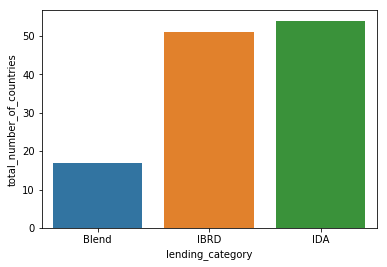

In [ ]:
lending_details = countries_details.groupby('lending_category').count().reset_index()
lending_details = lending_details[['lending_category', 'country_code']]
lending_details.columns= ['lending_category', 'total_number_of_countries']
sns.barplot(x = 'lending_category', y = 'total_number_of_countries', data = lending_details)
plt.show()

** Two major lending types are IBRD and IDA. **

Let's understand what system of trade most of the countries use.

In [ ]:
## Assign black column value undefine
countries_details.loc[countries_details['system_of_trade'] == '', 'system_of_trade'] = 'undefined'
countries_details['system_of_trade'].unique()

array([None, 'General trade system', 'Special trade system'], dtype=object)

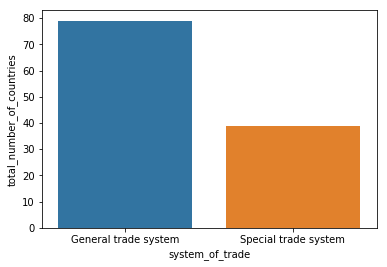

In [ ]:
trading_details = countries_details.groupby('system_of_trade').count().reset_index()
trading_details = trading_details[['system_of_trade', 'country_code']]
trading_details.columns= ['system_of_trade', 'total_number_of_countries']
sns.barplot(x = 'system_of_trade', y = 'total_number_of_countries', data = trading_details)
plt.show()

In [ ]:
special_trade_countries = countries_details[countries_details['system_of_trade'] == 'Special trade system'][['country_code', 'short_name', 'region']]
special_trade_countries.head()

,country_code,short_name,region
19,DMA,Dominica,Latin America & Caribbean
20,GRD,Grenada,Latin America & Caribbean
22,VCT,St. Vincent and the Grenadines,Latin America & Caribbean
24,CMR,Cameroon,Sub-Saharan Africa
25,COG,Congo,Sub-Saharan Africa


In [ ]:
special_trade_countries_region_wise = special_trade_countries.groupby(['region']).count().reset_index()
special_trade_countries_region_wise.drop(['short_name'], axis = 1, inplace=True)
special_trade_countries_region_wise.columns = ['region', 'number_of_countries']

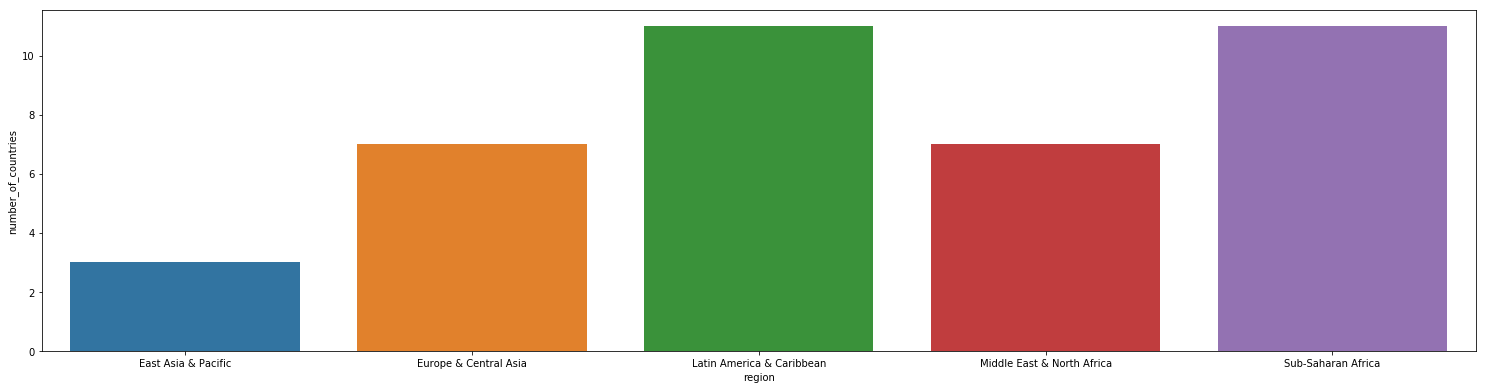

In [ ]:
a4_dims = (25.7, 6.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot('region', 'number_of_countries', data=special_trade_countries_region_wise)
plt.show()

** Most of the countries engaged in special trade are from `Latin America & Caribbean` and `Sub-Saharan Africa` **

Moving further let's check government accounting concept countries are using

In [ ]:
countries_details['government_accounting_concept'].unique()

array([None, 'Budgetary central government',
       'Consolidated central government'], dtype=object)

In [ ]:
## Assign black column value to undefine
countries_details.loc[countries_details['government_accounting_concept'] == '', 'government_accounting_concept'] = 'undefined'

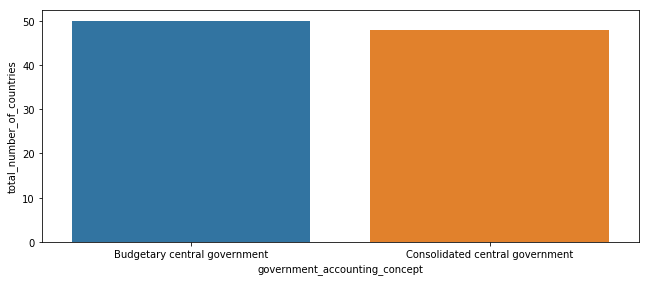

In [ ]:
a4_dims = (10.7, 4.27)
fig, ax = plt.subplots(figsize=a4_dims)
gove_accounting_details = countries_details.groupby('government_accounting_concept').count().reset_index()
gove_accounting_details = gove_accounting_details[['government_accounting_concept', 'country_code']]
gove_accounting_details.columns= ['government_accounting_concept', 'total_number_of_countries']
sns.barplot(x = 'government_accounting_concept', y = 'total_number_of_countries', data = gove_accounting_details)
plt.show()

- The number of countries using each type of IMF data dissemination standard is equal.


Investigate which countries adopt specific IMF data dissemination standards.

In [ ]:
countries_details.loc[countries_details['imf_data_dissemination_standard'] == '', 'imf_data_dissemination_standard'] = 'undefined'

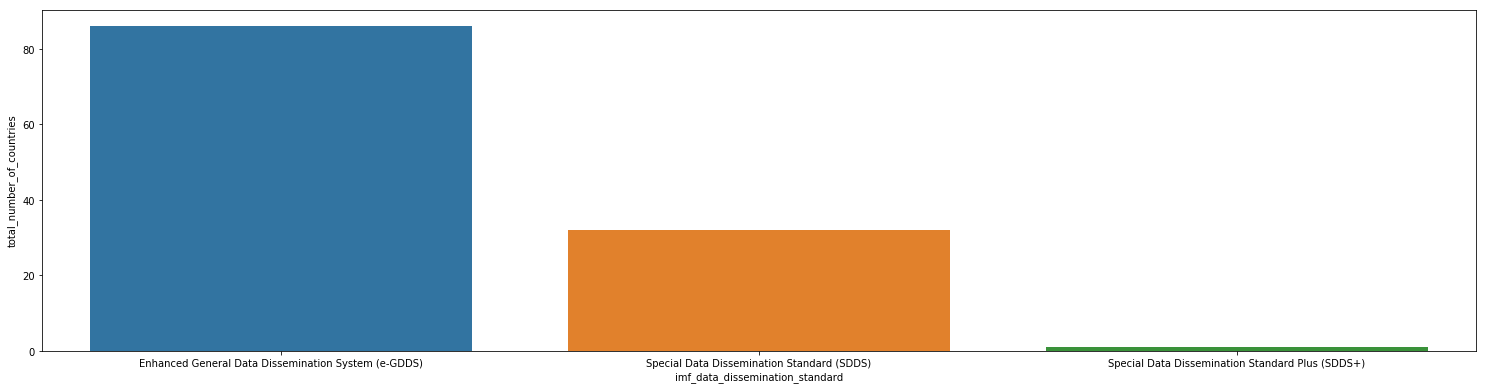

In [ ]:

a4_dims = (25.7, 6.27)
fig, ax = plt.subplots(figsize=a4_dims)
imf_data_dissemination_standard_details = countries_details.groupby('imf_data_dissemination_standard').count().reset_index()
imf_data_dissemination_standard_details  = imf_data_dissemination_standard_details [['imf_data_dissemination_standard', 'country_code']]
imf_data_dissemination_standard_details .columns= ['imf_data_dissemination_standard', 'total_number_of_countries']
sns.barplot(x = 'imf_data_dissemination_standard', y = 'total_number_of_countries', data = imf_data_dissemination_standard_details)
plt.show()

** As we can see most of the countries are using e-GDD5 which is also the latest one
**

## International debt

Let's  us now understand international debt.

In [ ]:
bq_assistant.head("international_debt", num_rows=5)

,country_name,country_code,indicator_name,indicator_code,value,year
0,Chad,TCD,GNI (current US$),NY.GNP.MKTP.CD,None,None
1,Chad,TCD,GNI (current US$),NY.GNP.MKTP.CD,None,None
2,Chad,TCD,GNI (current US$),NY.GNP.MKTP.CD,None,None
3,Chad,TCD,GNI (current US$),NY.GNP.MKTP.CD,None,None
4,Chad,TCD,GNI (current US$),NY.GNP.MKTP.CD,None,None


In [ ]:
total_countries = wbid.query_to_pandas_safe("""SELECT count(distinct(country_name)) from `bigquery-public-data.world_bank_intl_debt.international_debt`""")
total_rows = wbid.query_to_pandas_safe("""SELECT count(country_name) from `bigquery-public-data.world_bank_intl_debt.international_debt`""")
total_indicators = wbid.query_to_pandas_safe("""SELECT count(distinct(indicator_code)) from `bigquery-public-data.world_bank_intl_debt.international_debt`""")
print('Total Number of countries are', total_countries.iloc[0,0])
print('Total Number of indicators are', total_indicators.iloc[0,0])
print('Total Number of rows are', total_rows.iloc[0,0])

Total Number of countries are 135
Total Number of indicators are 497
Total Number of rows are 3284415


In [ ]:
bq_assistant.table_schema('international_debt')

[SchemaField('country_name', 'STRING', 'NULLABLE', '', ()),
 SchemaField('country_code', 'STRING', 'NULLABLE', '', ()),
 SchemaField('indicator_name', 'STRING', 'NULLABLE', '', ()),
 SchemaField('indicator_code', 'STRING', 'NULLABLE', '', ()),
 SchemaField('value', 'FLOAT', 'NULLABLE', '', ()),
 SchemaField('year', 'INTEGER', 'NULLABLE', '', ())]

## Let's  check yearwise debt of each country

In [ ]:
total_debt = """
SELECT country_name, country_code, year, sum(value) from `bigquery-public-data.world_bank_intl_debt.international_debt` group by country_code, year, country_name
"""

In [ ]:
yearwise_debt = wbid.query_to_pandas_safe(total_debt)
yearwise_debt.columns = ['country_name', 'country_code', 'year', 'debt']
yearwise_debt.head()

,country_name,country_code,year,debt
0,Chad,TCD,None,2.468234e+10
1,Fiji,FJI,None,1.362215e+10
2,Mali,MLI,None,7.901860e+10
3,Peru,PER,None,7.200822e+11
4,Togo,TGO,None,3.035996e+10


In [ ]:
yearwise_debt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 4 columns):
country_name    135 non-null object
country_code    135 non-null object
year            0 non-null object
debt            135 non-null float64
dtypes: float64(1), object(3)
memory usage: 4.3+ KB


In [ ]:
yearwise_debt.describe()

,debt
count,1.350000e+02
mean,2.347740e+12
std,8.461346e+12
min,1.588356e+09
25%,3.205510e+10
50%,1.580513e+11
75%,7.524467e+11
max,6.150682e+13


In [ ]:
## Converting year attribute to datetime datatype
yearwise_debt['year'] = pd.to_datetime(yearwise_debt['year'], format='%Y')

#### Let's plot yearwise debt of some countries

In [ ]:
## Plotting debt vs year graph
def plot_debt(country_code, country_name = None):
    country_yearwise_debt = yearwise_debt[yearwise_debt['country_code'] == country_code]
    plt.plot_date(country_yearwise_debt['year'], country_yearwise_debt['debt'])
    plt.xlabel('Years')
    plt.ylabel('Debt')
    if country_name is None:
        country_name = country_code
    plt.title(country_name + ' yearly debt analysis')

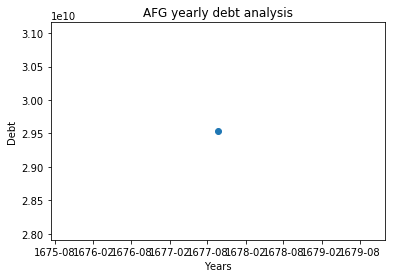

In [ ]:
plot_debt('AFG')
plt.show()

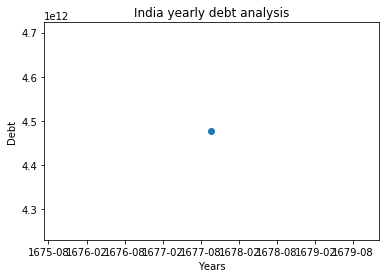

In [ ]:
plot_debt('IND', 'India')
plt.show()

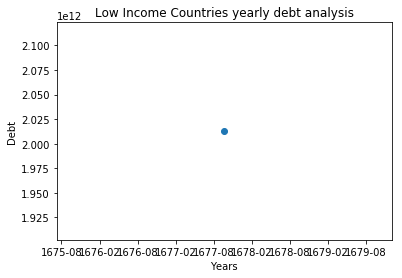

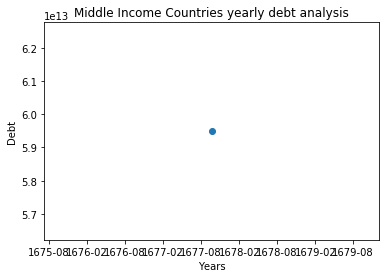

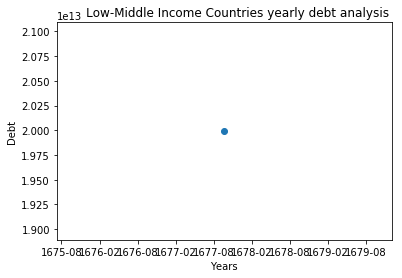

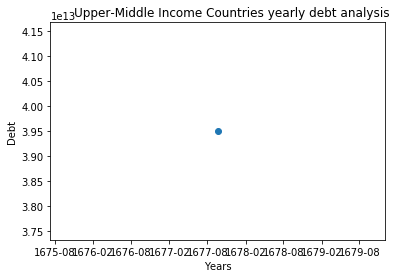

In [ ]:
plt.figure(1)
plot_debt('LIC', 'Low Income Countries')
plt.figure(2)
plot_debt('MIC', 'Middle Income Countries')
plt.figure(3)
plot_debt('LMC', '       Low-Middle Income Countries')
plt.figure(4)
plot_debt('UMC', '       Upper-Middle Income Countries')
plt.show()

*Here are two things I like to point out.*
* ** All the  curves are looking more or less same which implies that the trend of lending money is irrespective of income class of the country**
* ** Upper Middle class countries have more debt that any other class**

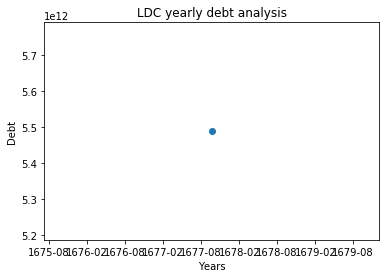

In [ ]:
plot_debt('LDC')
plt.show()

In [ ]:
countries_details.head()

,country_code,short_name,table_name,long_name,two_alpha_code,currency_unit,special_notes,region,income_group,wb_2_code,national_accounts_base_year,national_accounts_reference_year,sna_price_valuation,lending_category,other_groups,system_of_national_accounts,alternative_conversion_factor,ppp_survey_year,balance_of_payments_manual_in_use,external_debt_reporting_status,system_of_trade,government_accounting_concept,imf_data_dissemination_standard,latest_population_census,latest_household_survey,source_of_most_recent_Income_and_expenditure_data,vital_registration_complete,latest_agricultural_census,latest_industrial_data,latest_trade_data,latest_water_withdrawal_data
0,EAP,East Asia & Pacific (excluding high income),East Asia & Pacific (excluding high income),East Asia & Pacific (excluding high income),4E,None,East Asia and Pacific regional aggregate (does...,None,None,4E,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None
1,ECA,Europe & Central Asia (excluding high income),Europe & Central Asia (excluding high income),Europe & Central Asia (excluding high income),7E,None,Europe and Central Asia regional aggregate (do...,None,None,7E,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None
2,IDX,IDA only,IDA only,IDA only,XI,None,IDA only group aggregate.,None,None,XI,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None
3,LAC,Latin America & Caribbean (excluding high income),Latin America & Caribbean (excluding high income),Latin America & Caribbean (excluding high income),XJ,None,Latin America and Caribbean regional aggregate...,None,None,XJ,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None
4,LDC,Least developed countries: UN classification,Least developed countries: UN classification,Least developed countries: UN classification,XL,None,Least developed countries (UN classification) ...,None,None,XL,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None


Let's check how many countries each region consist

In [ ]:
country_region_dynamics = countries_details.groupby(['region']).count().reset_index()
country_region_dynamics = country_region_dynamics[['region', 'country_code']]
country_region_dynamics.columns = ['region', 'number_of_countries']

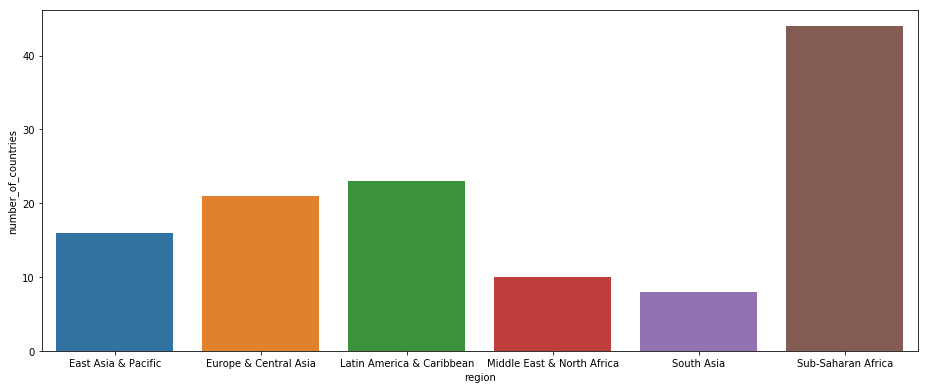

In [ ]:
a4_dims = (15.7, 6.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot('region', 'number_of_countries', data=country_region_dynamics)
plt.show()

** Sub saharan Africa region consists highest number  of countries**

Let's now find out dynamics between income_group and countries

In [ ]:
inc_countries = """
SELECT distinct country_name,cs.income_group  from `bigquery-public-data.world_bank_intl_debt.international_debt` as id join `bigquery-public-data.world_bank_intl_debt.country_summary` as cs on id.country_code = cs.country_code where cs.income_group != ''
"""

In [ ]:
income_county_dynamic = wbid.query_to_pandas_safe(inc_countries)

In [ ]:
income_county_dynamic.head()

,country_name,income_group
0,Afghanistan,Low income
1,Angola,Lower middle income
2,Albania,Upper middle income
3,Argentina,Upper middle income
4,Armenia,Upper middle income


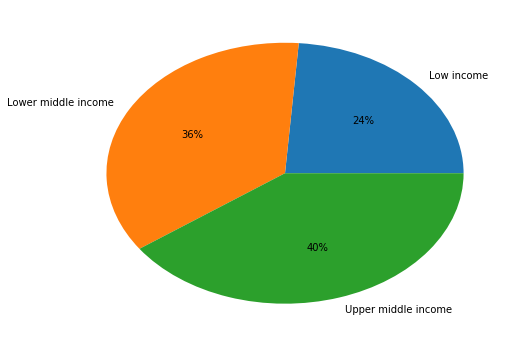

In [ ]:
country_per_income_grp = income_county_dynamic.groupby(['income_group']).count().reset_index()
country_per_income_grp.columns = ['income_group', 'total_number_of_countries']
a4_dims = (8, 6)
fig, ax = plt.subplots(figsize=a4_dims)
plt.pie(labels=country_per_income_grp['income_group'], x=country_per_income_grp['total_number_of_countries'], autopct='%1.0f%%')
plt.show()

Most of the countries are in Lower Middle income group. But the strange thing is  number of Upper Middle income countries are greater than number of  Low income data

In [ ]:
yearwise_debt[yearwise_debt['debt'] == yearwise_debt['debt'].max()]

,country_name,country_code,year,debt
120,Low & middle income,LMY,NaT,6.150682e+13


**Low and middle income countries took the greatest debt of all time in year 2014**

### Finding all the Low and Middle income  countries

In [ ]:
lmy_countries = """
SELECT distinct(country_name) from `bigquery-public-data.world_bank_intl_debt.international_debt` as id join `bigquery-public-data.world_bank_intl_debt.country_summary` as cs on id.country_code = cs.country_code where  cs.income_group = 'Lower middle income'
"""

In [ ]:
## List of lower middle class countries
response1 = wbid.query_to_pandas_safe(lmy_countries)
response1

,country_name
0,Ghana
1,India
2,Kenya
3,Sudan
4,Angola
5,Bhutan
6,Zambia
7,Bolivia
8,Comoros
9,Lao PDR


### Let's Analyse regions

In [ ]:
no_income_group = wbid.query_to_pandas_safe("""SELECT country_code, short_name from `bigquery-public-data.world_bank_intl_debt.country_summary` where income_group = ''""")
no_income_group.head()

,country_code,short_name


In [ ]:
yearwise_debt.head()

,country_name,country_code,year,debt
0,Chad,TCD,NaT,2.468234e+10
1,Fiji,FJI,NaT,1.362215e+10
2,Mali,MLI,NaT,7.901860e+10
3,Peru,PER,NaT,7.200822e+11
4,Togo,TGO,NaT,3.035996e+10


In [ ]:
## region wise debt
debt_region_wise = yearwise_debt.merge(no_income_group, how = 'inner', on='country_code')

In [ ]:
debt_region_wise.head()

,country_name,country_code,year,debt,short_name


In [ ]:
debt_region_wise['country_code'].unique()

array([], dtype=object)

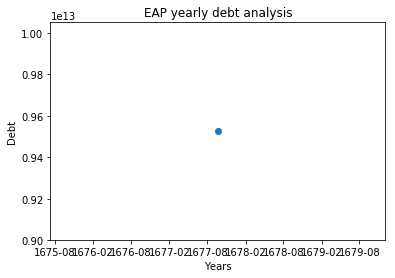

In [ ]:
plot_debt('EAP')
plt.show()

In [ ]:
## Region with the highest and the lowest debt
print(debt_region_wise[debt_region_wise['country_code'] == debt_region_wise['country_code'].max()]['country_code'].unique())
print(debt_region_wise[debt_region_wise['country_code'] == debt_region_wise['country_code'].min()]['country_code'].unique())

[]
[]


Upper middle-income countries have the highest debt, while East Asia & Pacific countries have the lowest debt.

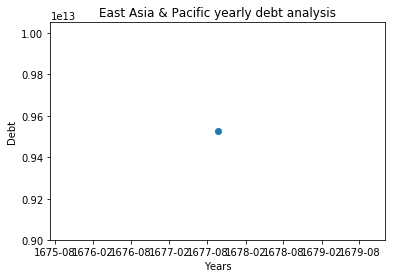

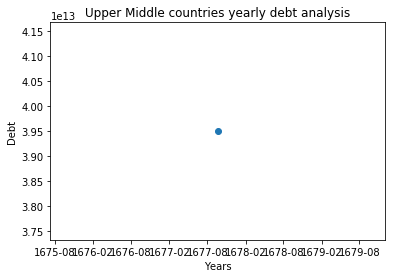

In [ ]:
plt.figure(1)
plot_debt('EAP', 'East Asia & Pacific')
plt.figure(2)
plot_debt('UMC', 'Upper Middle countries')
plt.show()

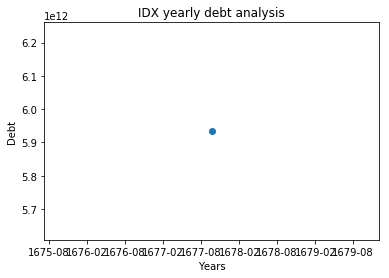

In [ ]:
plot_debt('IDX')

## Series Summary

In [ ]:
bq_assistant.head("series_summary", num_rows=5)

,series_code,topic,indicator_name,short_definition,long_definition,unit_of_measure,periodicity,base_period,other_notes,aggregation_method,limitations_and_exceptions,notes_from_original_source,general_comments,source,statistical_concept_and_methodology,development_relevance,related_source_links,other_web_links,related_indicators,license_type
0,BM.GSR.TOTL.CD,Economic Policy & Debt: Balance of payments: C...,"Imports of goods, services and primary income ...","Imports of goods, services and primary income ...","Imports of goods, services and income is the s...",None,Annual,None,None,Gap-filled total,None,None,None,"International Monetary Fund, Balance of Paymen...",None,None,None,None,None,None
1,BN.CAB.XOKA.CD,Economic Policy & Debt: Balance of payments: C...,Current account balance (current US$),Current account balance shows the difference b...,Current account balance shows the difference b...,None,Annual,None,None,Sum,None,None,None,"International Monetary Fund, Balance of Paymen...",None,None,None,None,None,None
2,BX.GRT.EXTA.CD.DT,Economic Policy & Debt: Balance of payments: R...,"Grants, excluding technical cooperation (curre...",Grants are defined as legally binding commitme...,Grants are defined as legally binding commitme...,None,Annual,None,None,Sum,None,None,None,"World Bank, International Debt Statistics.",None,None,None,None,None,None
3,BX.GRT.TECH.CD.DT,Economic Policy & Debt: Balance of payments: R...,Technical cooperation grants (current US$),Technical cooperation grants include free-stan...,Technical cooperation grants include free-stan...,None,Annual,None,None,Sum,None,None,None,"World Bank, International Debt Statistics.",None,None,None,None,None,None
4,BX.GSR.TOTL.CD,Economic Policy & Debt: Balance of payments: C...,"Exports of goods, services and primary income ...","Exports of goods, services and primary income ...","Exports of goods, services and income is the s...",None,Annual,None,None,Gap-filled total,None,None,None,"International Monetary Fund, Balance of Paymen...",None,None,None,None,None,None


In [ ]:
bq_assistant.table_schema('series_summary')

[SchemaField('series_code', 'STRING', 'NULLABLE', None, ()),
 SchemaField('topic', 'STRING', 'NULLABLE', None, ()),
 SchemaField('indicator_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('short_definition', 'STRING', 'NULLABLE', None, ()),
 SchemaField('long_definition', 'STRING', 'NULLABLE', None, ()),
 SchemaField('unit_of_measure', 'STRING', 'NULLABLE', None, ()),
 SchemaField('periodicity', 'STRING', 'NULLABLE', None, ()),
 SchemaField('base_period', 'STRING', 'NULLABLE', None, ()),
 SchemaField('other_notes', 'STRING', 'NULLABLE', None, ()),
 SchemaField('aggregation_method', 'STRING', 'NULLABLE', None, ()),
 SchemaField('limitations_and_exceptions', 'STRING', 'NULLABLE', None, ()),
 SchemaField('notes_from_original_source', 'STRING', 'NULLABLE', None, ()),
 SchemaField('general_comments', 'STRING', 'NULLABLE', None, ()),
 SchemaField('source', 'STRING', 'NULLABLE', None, ()),
 SchemaField('statistical_concept_and_methodology', 'STRING', 'NULLABLE', None, ()),
 SchemaField('

In [ ]:
response1 = wbid.query_to_pandas_safe("""SELECT distinct(periodicity) from `bigquery-public-data.world_bank_intl_debt.series_summary` """)
response1

,periodicity
0,Annual


## series_times

In [ ]:
bq_assistant.head("series_times", num_rows=5)

,series_code,year,description
0,DT.DOD.PVLX.CD,2018,Present value calculations for these countries...


In [ ]:
code_region_mapping = countries_details[['country_code', 'region']]

In [ ]:
total_debt = yearwise_debt.groupby(by=['country_code']).sum().reset_index()

In [ ]:
total_debt.head()

,country_code,debt
0,AFG,2.953522e+10
1,AGO,7.595210e+11
2,ALB,7.967154e+10
3,ARG,3.573142e+12
4,ARM,1.238981e+11


In [ ]:
total_debt = total_debt.merge(code_region_mapping)

In [ ]:
total_debt['region'].unique()

array(['South Asia', 'Sub-Saharan Africa', 'Europe & Central Asia',
       'Latin America & Caribbean', 'East Asia & Pacific',
       'Middle East & North Africa', None], dtype=object)

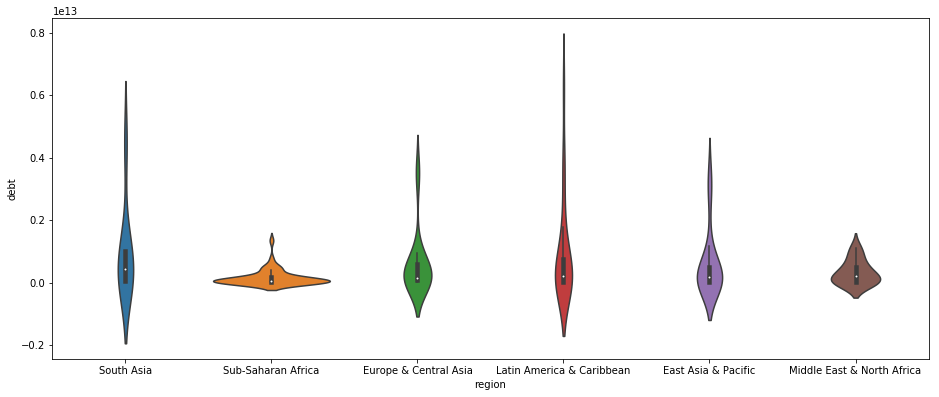

In [ ]:
a4_dims = (15.7, 6.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.violinplot('region', 'debt', data=total_debt)
plt.show()

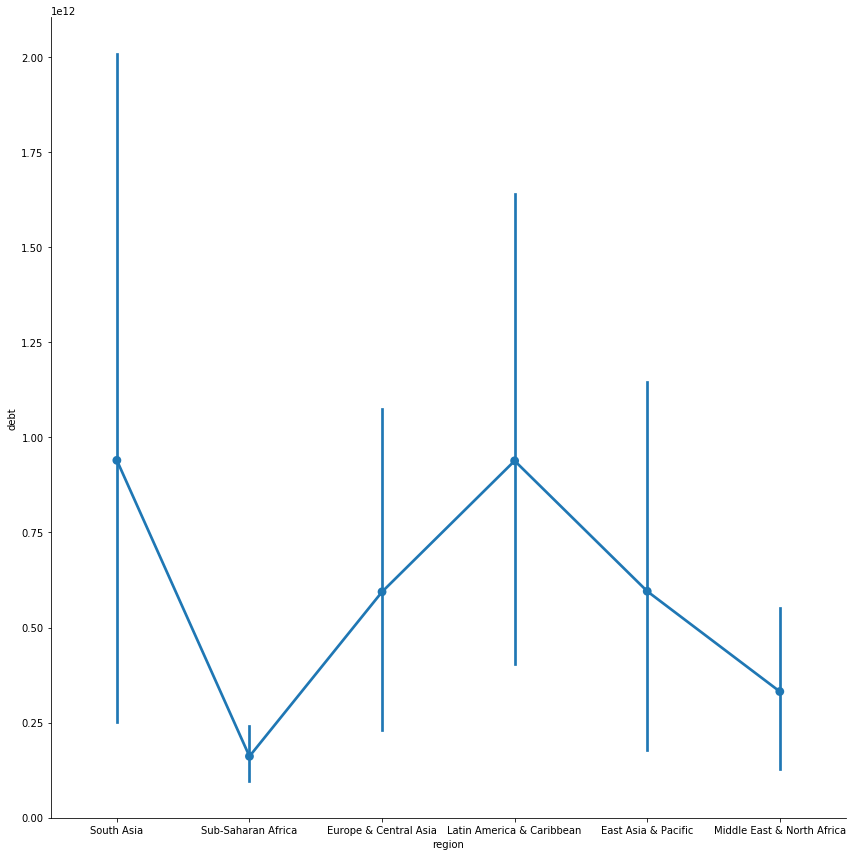

In [ ]:
#a4_dims = (15.7, 6.27)
#fig, ax = plt.subplots(figsize=a4_dims)
sns.factorplot('region', 'debt', data=total_debt, size=12)
plt.show()

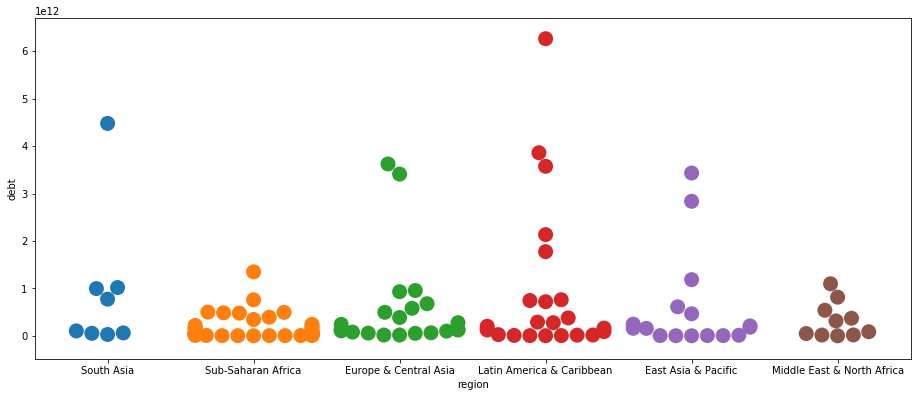

In [ ]:
a4_dims = (15.7, 6.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.swarmplot('region', 'debt', data=total_debt, size=15)
plt.show()

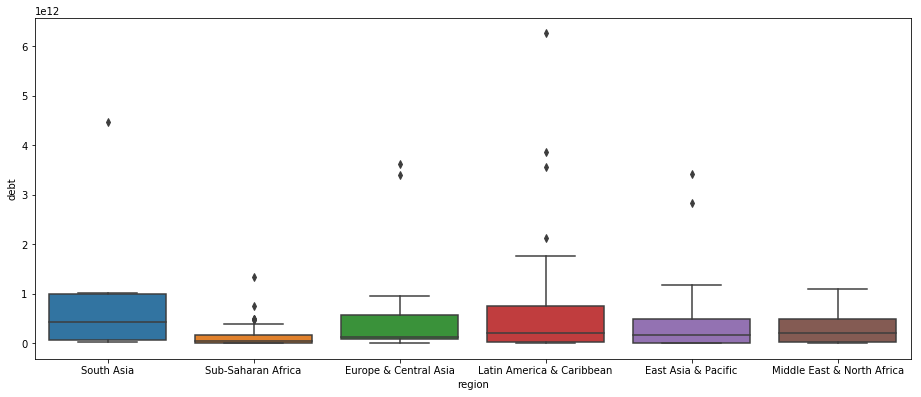

In [ ]:
a4_dims = (15.7, 6.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot('region', 'debt', data=total_debt)
plt.show()

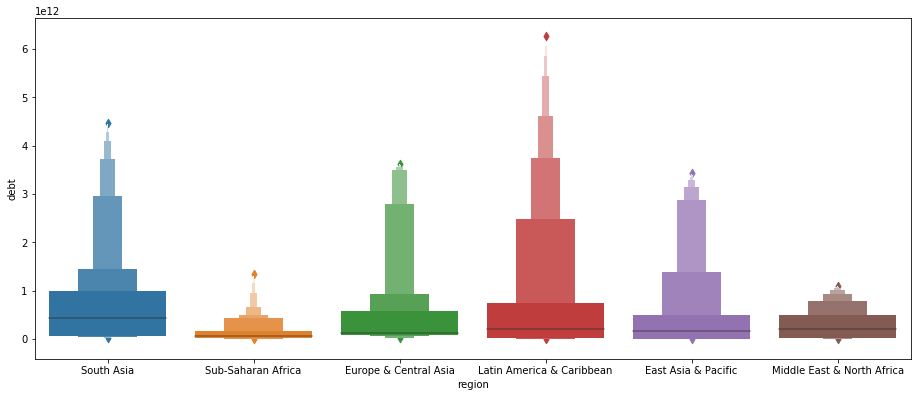

In [ ]:
a4_dims = (15.7, 6.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lvplot('region', 'debt', data=total_debt)
plt.show()

- Sub-Saharan Africa: Lowest variance and average debt.
- East Asia and Pacific: Highest average debt, with one country having exceptionally high debt.
- Europe and Central Asia vs. Latin America and Caribbean: Similar debt patterns.

Identify the country in the East Asia and Pacific region with an exceptionally high debt.

In [ ]:
total_debt[total_debt['debt'] == total_debt['debt'].max()]

,country_code,debt,region
69,LMY,6.150682e+13,None


China took total debt of about 26 trillion USD


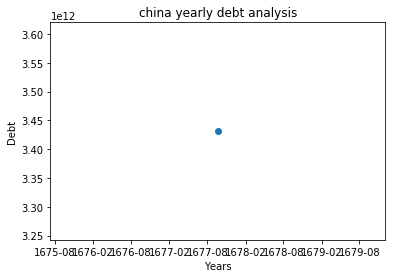

In [ ]:
plot_debt('CHN', 'china')
plt.show()

In [ ]:
code_lending_mapping = countries_details[['country_code', 'lending_category']]

In [ ]:
total_debt = total_debt.merge(code_lending_mapping)

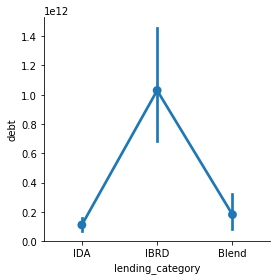

In [ ]:
sns.factorplot('lending_category', 'debt', data=total_debt)
plt.show()

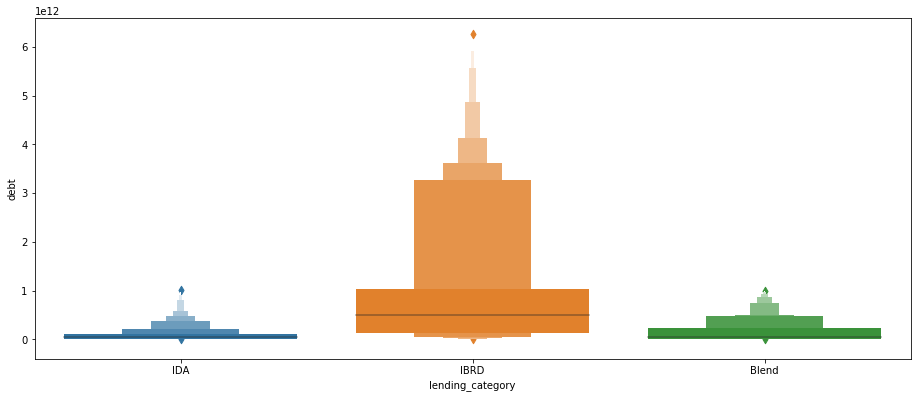

In [ ]:
a4_dims = (15.7, 6.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lvplot('lending_category', 'debt', data=total_debt)
plt.show()

*We can draw following conclusions from above plots:-*
* ** Very few countries have IDA blend policy for lending**
* ** Most of the countries have taken IBRD policy for lending**